In [148]:
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from torchsummary import summary
from pytorch_toolbelt import losses as L

set seed to get reproducible results

In [149]:
seed =20
torch.backends.cudnn.deterministic= True
torch.backends.cudnn.benchmark= False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


In [150]:
#model = sbm.PhaseNet.from_pretrained("instance")
model = sbm.EQTransformer.from_pretrained("original")
#model = sbm.PhaseNet(phases="PSN")
model.cuda();
data = sbd.Iquique(sampling_rate=100)
train, dev, test = data.train_dev_test()
print(model)
#summary(model, (6000, 3))

2022-10-09 14:53:27,314 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb


Component order:	ZNE
SeisBench model		EQTransformer

EQTransformer(
  (encoder): Encoder(
    (convs): ModuleList(
      (0): Conv1d(3, 8, kernel_size=(11,), stride=(1,), padding=(5,))
      (1): Conv1d(8, 16, kernel_size=(9,), stride=(1,), padding=(4,))
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=(3,))
      (3): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
      (4): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (5): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (pools): ModuleList(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): MaxP

def convert_relu_to_softplus(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.Softmax):
            setattr(model, child_name, nn.SiLU())
        else:
            convert_relu_to_softplus(child)

new = convert_relu_to_softplus(model)
print(model)

for param in model.parameters():
    param.requires_grad = False
    #print(param.requires_grad)

model.out.weight.requires_grad = True
model.up4.weight.requires_grad = True
#model.up3.weight.requires_grad = True
#model.up2.weight.requires_grad = True
#model.up1.weight.requires_grad = True
#model.conv4.conv.weight.requires_grad = True
#model.conv3.conv.weight.requires_grad = True

#for param in model.parameters():
    #param.requires_grad = False
    #print(param.requires_grad)

In [151]:
generator = sbg.GenericGenerator(data)

@generator.augmentation
def print_state_dict(state_dict):
    print(state_dict)

generator[2]['X'];

{'X': (array([[198.29475309, 203.29475309, 210.29475309, ..., -28.70524691,
        -43.70524691, -61.70524691],
       [-67.81648663, -50.81648663, -49.81648663, ..., -91.81648663,
        -80.81648663, -66.81648663],
       [ 81.47247942,  66.47247942,  56.47247942, ..., -75.52752058,
        -55.52752058, -43.52752058]]), {'source_origin_time': '2014-05-01T00:52:20.970000Z', 'source_latitude_deg': -19.4527, 'source_longitude_deg': -69.9762, 'source_depth_km': 57.95, 'path_back_azimuth_deg': 329.936310182, 'station_network_code': 'DG', 'station_code': 'IN17', 'trace_channel': 'HH*', 'station_location_code': nan, 'station_latitude_deg': -20.48, 'station_longitude_deg': -69.35, 'station_elevation_m': 1278.0, 'trace_name': 'bucket0$2,:3,:15552', 'trace_sampling_rate_hz': 100, 'trace_completeness': 1.0, 'trace_has_spikes': False, 'trace_start_time': '2014-05-01T00:52:20.740000Z', 'trace_P_arrival_sample': 2000.0, 'trace_S_arrival_sample': 3551.0, 'trace_name_original': 'DG.IN17.', 'trace

In [152]:
phase_dict = {
    "trace_P_arrival_sample": "P",
    "trace_S_arrival_sample": "S",
}

In [153]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=9000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=6000, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=3, dim=0)
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)

In [154]:
batch_size = 1
num_workers = 1  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)
test_loader = DataLoader(test_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

In [155]:
train_loader

In [156]:
learning_rate = 1e-3
epochs = 1
loss_weight = torch.tensor([1, 1, 0.01]).to(model.device) # PSN
loss_weight = torch.reshape(loss_weight, (1,3,1))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
cross_ent = torch.nn.CrossEntropyLoss()


def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
    #h = y_true * torch.log(y_pred + eps)
    h = y_true * torch.log(y_pred + eps)
    #print (h)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h


def fo_loss_fn(y_pred, y_true,gamma=3, eps=1e-5):
    # vector cross entropy loss
    #h = y_true * torch.log(y_pred + eps)
    h = (1-y_true)**gamma * torch.log(y_pred + eps)
    #print (h)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h


import torch
import torch.nn.functional as F
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        '''
        :param inputs: batch_size * dim
        :param targets: (batch,)
        :return:
        '''
        bce_loss = F.cross_entropy(inputs, targets)
        loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
        return loss

focal_loss = FocalLoss()

In [157]:
from collections import Counter

In [158]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.a = torch.nn.parameter.Parameter(data = torch.tensor(1.), requires_grad = True)


    def forward(self, outputs: torch.Tensor, labels: torch.Tensor):
        
        SMOOTH = 1e-1

        n=torch.argmax(labels.to(model.device),axis=1)
        m=torch.argmax(outputs,axis=1)
        ####
        #print(torch.unique(n))
        #print('--------- labels-----------')
        #print(torch.nn.functional.one_hot(n).sum (dim = 1))
        #print('--------- Outputs-----------')
        #print(torch.nn.functional.one_hot(m).sum (dim = 1))
        ####
        arg_labels_p =  torch.where(n == 0, 1, 0)
        arg_outputs_p = torch.where(m == 0, 1, 0)
    
        intersection_p = torch.sum(arg_outputs_p * arg_labels_p)
        #print(intersection_p)
        union_p = (arg_outputs_p | arg_labels_p).float().sum()       
        iou_p = (intersection_p + SMOOTH) / (union_p + SMOOTH) 
        #print(iou_p)
        dic_loss_p = 1 - (2*iou_p)/(iou_p+1)
        loss_p = torch.log(torch.cosh(dic_loss_p))
        

        arg_labels_s =  torch.where(n == 1, 1, 0)
        arg_outputs_s = torch.where(m == 1, 1, 0)
        
        intersection_s = torch.sum(arg_outputs_s * arg_labels_s)
        union_s = (arg_outputs_s | arg_labels_s).float().sum()       
        iou_s = (intersection_s + SMOOTH) / (union_s + SMOOTH) 
        dic_loss_s = 1 - (2*iou_s)/(iou_s+1)
        loss_s = torch.log(torch.cosh(dic_loss_s))
        #loss = dic_loss_p + dic_loss_s
        loss = loss_s + loss_p
        
        
        loss = self.a*(loss)
        print(loss)
        return loss

In [159]:
dic_loss = DiceLoss()
#dic_loss = L.DiceLoss(mode = 'multiclass')

In [160]:
batch = next(iter(train_loader))
batch['X'].max()

tensor(1.)

In [168]:
def train_loop(dataloader,t):
    model.train()
    size = len(dataloader.dataset)
    batch = next(iter(dataloader))
    #for batch_id, batch in enumerate(dataloader):
    # Compute prediction and loss
    #print(batch["X"].size())
    pred = model(batch["X"].to(model.device))
    #v = -torch.mean(torch.sum(batch["X"].view(batch_size, -1) * torch.log(pred.view(batch_size, -1)), dim=1))
    third_tensor = torch.cat((pred[1], pred[2], 1-(pred[1]+pred[2])), 0).reshape(batch_size,3,6000)
    print(torch.sum(third_tensor,1))
    #loss = dic_loss(pred, batch["y"].to(model.device))
    loss =loss_fn(third_tensor, batch["y"].to(model.device))
    #loss = cross_ent(third_tensor, batch["y"].to(model.device))
    #if t % 10 == 0:
    #    print(loss)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()
    #print(torch.autograd.grad(loss, list(model.parameters())))
    return loss
    '''
    if batch_id % 5 == 0:
        loss, current = loss.item(), batch_id * batch["X"].shape[0]
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    '''    

def test_loop(dataloader):
    #num_batches = len(dataloader)
    #test_loss = 0
    model.eval()
    batch = next(iter(dataloader))
    with torch.no_grad():
        #for batch in dataloader:
        pred = model(batch["X"].to(model.device))
        third_tensor = torch.cat((pred[1], pred[2], 1-(pred[1]+pred[2])), 0).reshape(batch_size,3,6000)
    
        #loss = dic_loss(pred, batch["y"].to(model.device))
        test_loss =loss_fn(third_tensor, batch["y"].to(model.device))
        #test_loss= dic_loss(pred, batch["y"].to(model.device)).item()
        #test_loss = loss_fn(pred, batch["y"].to(model.device)).item()

    #test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")
    return test_loss
    

tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<SumBackward1>)
tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<SumBackward1>)


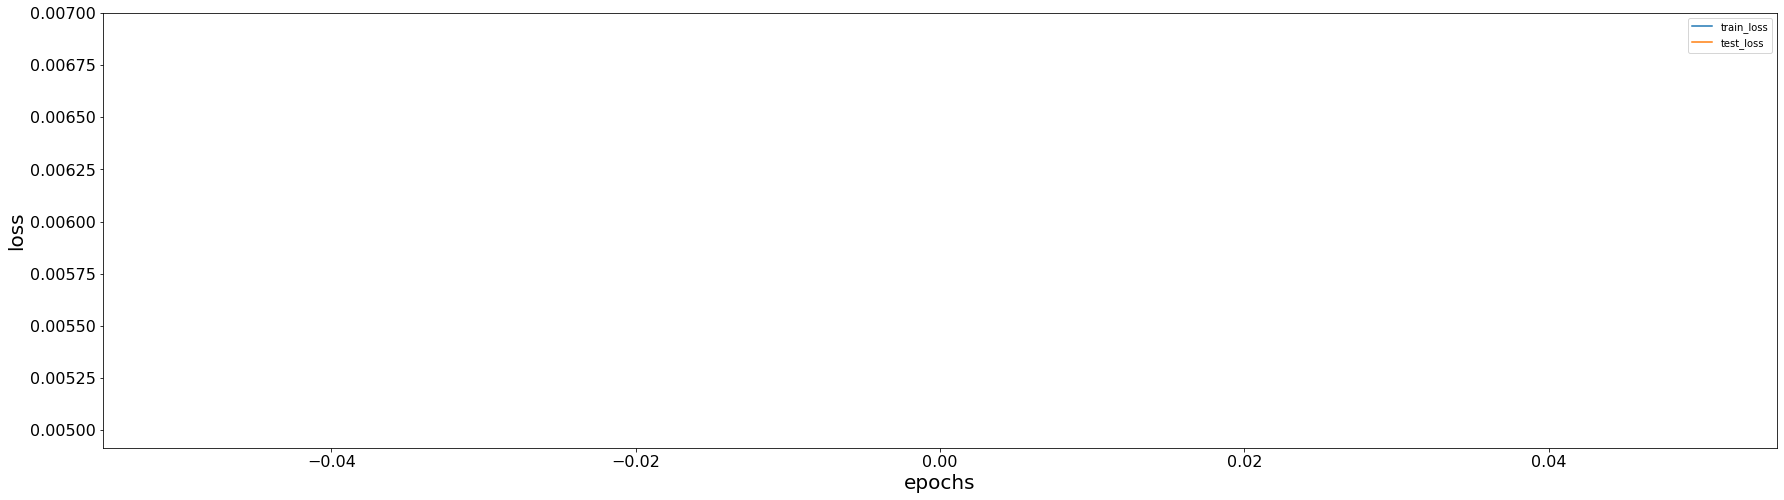

In [169]:
import matplotlib.pyplot as plt
tot_train_loss = np.zeros((1, epochs))
tot_test_loss = np.zeros((1, epochs))
for t in range(epochs):
    #if t % 10 == 0:
        #print(f"Epoch {t+1}\n-------------------------------")
    loss_train = train_loop(train_loader,t)
    #print(loss_train)
    for param in model.parameters():
        if param.requires_grad == False:
            print('grad_ouput doesnt have grad')
    tot_train_loss[0,t]= loss_train.cpu().detach().numpy()
    loss_test = train_loop(test_loader,t)
    tot_test_loss[0,t]= loss_test.cpu().detach().numpy()
    #print(loss.cpu().detach().numpy().tolist())
    #break
    

plt.plot (tot_train_loss[0,:], label='train_loss')
plt.plot (tot_test_loss[0,:], label='test_loss')
plt.rcParams["figure.figsize"] = (30,8)
plt.xlabel('epochs', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(loc='upper right')
    #break
    #model.eval()
    #test_loop(dev_loader)
    #test_loop(test_loader)